# CNN-ek - befejező notebook

## 0.) Inicializáló rész

Az előző notebookban (vagy mnég azelőtt) definiált segédfüggvények átemelése, melyet most is változtatás nélkül fogunk használni.

In [1]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.095
session = tf.Session(config=config) # Letrehozunk egy TF session-t a megfelelo mem. korlattal
K.set_session(session) # atadjuk azt a Kerasnak

Using TensorFlow backend.


In [2]:
import numpy as np
import math
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D 
from keras.layers import Concatenate, Lambda, Average, Add, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from random import sample as RS
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

def inTop3(x,y):
    return(top_k_categorical_accuracy(x,y,k=3))

In [3]:
from keras.datasets import cifar10

def mintak_cifar10():
    (x_tan,y_tan),(x_tst,y_tst)=cifar10.load_data()
    x_tan=x_tan.astype('float32')/255.0
    x_tst=x_tst.astype('float32')/255.0
    classes=['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    idx=RS(set(range(y_tan.size)),5)
    print('Mintakepek es a cimkeik: '+str([x[0] for x in y_tan[idx]]))
    print('Cimkehez tartozo osztalyok: '+str([classes[x[0]] for x in y_tan[idx]]))
    
    (f, sf)=plt.subplots(1, 5)
    f.set_size_inches(16, 6)
    
    for i in range(5):
        img = x_tan[idx[i]]
        sf[i].imshow(img)
    plt.show()
    
    y_tan=to_categorical(y_tan).astype('float32')
    y_tst=to_categorical(y_tst).astype('float32')
    return(x_tan,y_tan,x_tst,y_tst,classes)

def tanitas_earlystop(model, x_tan, y_tan, epn, tol):
    
    model_checkpoint = ModelCheckpoint('CNN.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
    earlystop=EarlyStopping(monitor='val_loss', patience=tol)
    hst=model.fit(x=x_tan, y=y_tan, verbose=1, batch_size=32, epochs=epn, callbacks=[earlystop, model_checkpoint], validation_split=0.1)
    model.load_weights('CNN.hdf5')
    
    plt.title('Tanito gorbek')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    epn=len(hst.history['loss'])
    
    epi=np.linspace(1,epn,epn)
    plt.plot(epi, hst.history['loss'], 'b-', epi, hst.history['val_loss'], 'r-')
    plt.legend(['tanito', 'validacios'], loc='upper left')
    plt.show()
    return model

def teszt(halo, x_test, y_test):
    
    tmp=halo.evaluate(x_test,y_test)
        
    y_pred=np.argmax(halo.predict(x_test),axis=1)
    print('Confusion Matrix:')
    print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
    print()
    print('Loss:'+str(tmp[0])+'; Acc:'+str(tmp[1])+'; Top3Acc:'+str(tmp[2]))
    print()
    return({'loss':tmp[0], 'acc':tmp[1], 'top3acc':tmp[2]})

def halo_mentes(model,nev):
    model_json=model.to_json()
    with open(nev+'.json','w') as json_file:
        json_file.write(model_json)
    model.save_weights(nev+'.hdf5')
    


Olvassuk be az adathalmazt

Mintakepek es a cimkeik: [2, 1, 9, 2, 1]
Cimkehez tartozo osztalyok: ['bird', 'auto', 'truck', 'bird', 'auto']


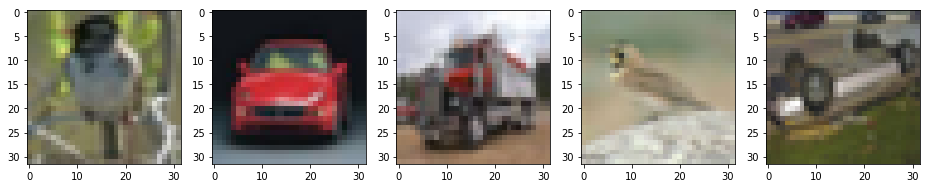

In [4]:
(x_tan,y_tan,x_tst,y_tst,cimke)=mintak_cifar10()

## 1.) Transfer learning alkalmazása

Sok esetben nincs elég tanítóminta a konvolúciós rétegek tanításához. Gyakoran alkalmazott forgatókönyv ilyenkor más, a feladatunkhoz lehetőleg legjobban hasonlító, de elegendő nagy mintazsámú halmazon betanított konvolúciós rétegekből álló háló, mint jellemzőkiemelő háló alkalmazása. Ennek kimenetét adjuk általában egy 1 rejtett rétegű MLP-nek, melynek feladata ebben az esetben a kapott jellemzők alapján a konkrét probléma megoldása.

### Transfer learninges háló létrehozása

Egészítsük ki úgy az alábbi kódrélszletet, hogy a MobileNet-et transfer learninges jellemzőkiemelőként használja fel. Figyeljük meg, hogy a Keras által külön nem támogatott, de a Tensorflow API-ja által tartalmazott, képeket átméretező réteget hogyan hívhatjuk meg (lambda rétegként).

In [5]:
def atmer(kep):
    return(K.tf.image.resize_images(kep, (128,128)))

from keras.applications import mobilenet

def get_tfn(x_t, y_t):
    bem = Input(shape=x_t[0].shape, dtype='float32')
    x = Lambda(atmer, input_shape=x_t[0].shape)(bem)
    
    rnt = mobilenet.MobileNet(input_shape=(128, 128, 3), include_top=False, input_tensor=x)
    
    y = MaxPooling2D(pool_size=(2, 2))(rnt.output)
    y = Flatten()(y)
    y = Dense(120 , activation='tanh')(y)
    y = Dense(y_t.shape[1], activation='softmax')(y)
    
    for layer in rnt.layers:
        layer.trainable=False
        
    model = Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    
    print(model.summary())
    
    return model

In [6]:
tfn=get_tfn(x_tan,y_tan)
tfn=tanitas_earlystop(tfn, x_tan, y_tan, 15, 5)
halo_mentes(tfn,'cnn_tf1')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

36576/45000 [=======================>......] - ETA: 3s - loss: 0.7858 - acc: 0.7337 - inTop3: 0.9314

KeyboardInterrupt: 

### Önálló feladat - tanítás gyorsítása 

Jelentősen lelassult egy tanító epoch futása, melynek oka, hogy a jellemzőkiemelést végző rétegen át kell kergetni a képeket. Mivel ezt minden epochnál meg kell tenni, ezért ez mindig overhead-et jelent. Érdemes ezért a jellemzőkiemelés eredmnényét egy változóban eltárolni, majd csak az ebben mentett bemenetekre a végső teljesen összekötött rétegeket tanítani. Persze nem alkalmazható a módszer, ha augmentálni is kívánunk futási időben.

In [7]:
def get_RNkim(x_t, y_t=None):
    
    bem = Input(shape=x_t[0].shape, dtype='float32')
    x = Lambda(atmer, input_shape=x_t[0].shape)(bem)
    
    rnt = mobilenet.MobileNet(input_shape=(128, 128, 3), include_top=False, input_tensor=x)
    
    y = MaxPooling2D(pool_size=(2, 2))(rnt.output)
    y = Flatten()(y)
    model=Model(inputs=bem, outputs=y)
    
    x_jel = model.predict(x_t)
    
    return (x_jel, model)

Definiáljukl a ResNet fölé kerülő hálót, mérete maradjon az előzőeknek megfelelő.

In [8]:
def get_tfMLP(x_t, y_t, bem=None):
    
    if (bem is None):
        bem = Input(shape=x_t[0].shape, dtype='float32')
    
    y = Dense(120 , activation='tanh')(bem)
    y = Dense(y_t.shape[1], activation='softmax')(y)
    
    model = Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    
    print(model.summary())
    return model
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               491640    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1210      
Total params: 492,850
Trainable params: 492,850
Non-trainable params: 0
_________________________________________________________________
None
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 6s 128us/step - loss: 0.7396 - acc: 0.7509 - inTop3: 0.9416 - val_loss: 0.6609 - val_acc: 0.7702 - val_inTop3: 0.9514

Epoch 00001: val_loss improved from inf to 0.66093, saving model to CNN.hdf5
Epoch 2/15
45000/45000 [==============================] - 6s 123us/step - loss: 0.6733 - acc

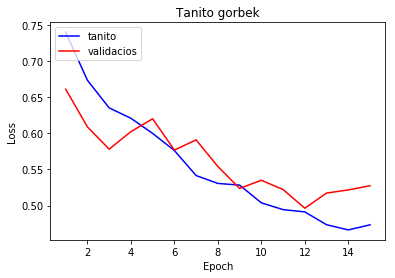

In [9]:
K.clear_session()
(x_RN, almod) = get_RNkim(x_tan, y_tan)
tfMLP = get_tfMLP(x_RN,y_tan)
tfMLP = tanitas_earlystop(tfMLP, x_RN, y_tan, 15, 5)
halo_mentes(tfMLP,'tf_MLP')

Eddigi legjobb eredményeket most sikerült elérni: 0.5-ös validációs loss, 82% feletti pontossággal

### Önálló feladat - MobileNet, illetve konstruált MLP összekpacsolása egy hálóba

Ahhoz, hogy az egészet egy hálóként tudjuk használni a két részhálót össze kell kapcsolnunk.

In [10]:
def link_transf(al_halo, fel_halo):
    bem = Input(shape=al_halo.layers[0].output_shape[1:4], dtype='float32')
    x=al_halo(bem)
    y=fel_halo(x)
    
    model=Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0, decay=0), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    return (model)


In [11]:
tran_halo=link_transf(almod, tfMLP)
halo_mentes(tran_halo,'transf_CNN')

### Teszthalmazon vizsgáljuk meg a háló teljesítményét

In [12]:
teszt(tran_halo,x_tst,y_tst)

10000/10000 [==============================] - 4s 387us/step
Confusion Matrix:
[[906   4  11  10  15   2   1   6  37   8]
 [ 20 929   0   1   0   1   3   1  14  31]
 [ 72   0 678  56  91  29  57   5  11   1]
 [ 25   2  25 753  49  86  30  17   8   5]
 [ 17   1  25  43 829  15  30  36   3   1]
 [  6   3  17 169  39 715  25  26   0   0]
 [  8   1  15  54  22  14 881   0   4   1]
 [ 19   2   5  39  71  36   6 817   4   1]
 [ 85  13   7   9   7   3   3   1 856  16]
 [ 31  77   0   5   2   0   1   5  15 864]]

Loss:0.5362028652191162; Acc:0.8228; Top3Acc:0.9651



{'loss': 0.5362028652191162, 'acc': 0.8228, 'top3acc': 0.9651}

## 2.) Ensemble

Különböző osztályozási versenyeket megnyerő neurális hálók kivétel nélkül szakértő együttesként, úgynevezett ensemble-ként épülnek fel. Megjegyzés: a dropout, mint exponenciálisan sok szakértőt előállító eljárás is ezen módszerekre vezethető vissza.

Mi most a k kereszt validáció során betanított hálókból hozzuk létre a szakértő együttesünket.

In [21]:
def ensemble(mf, x, y, epn, tol, db=3, bm=32):
    N=x.shape[0] 
    M=N//db
    idx=set(range(N))
    idxt=idx
    models=[None]*db
    
    model_chkp=ModelCheckpoint('enhalo.hdf5', monitor='val_loss', save_best_only=True)
    earlystop=EarlyStopping(monitor='val_loss', patience=tol)
    bem=Input(shape=x[0].shape, dtype='float32')
        
    for i in range(db):
        print(str(i+1)+'. halo tanitasa:')
        idxa=set(RS(idxt,M))
        idxt=idxt-idxa
        idxat=list(idx-idxa)
        idxav=list(idxa)
        x_val=x[idxav]
        y_val=y[idxav]
        x_tan=x[idxat]
        y_tan=y[idxat]
        models[i]=mf(x, y, bem)
        hst=models[i].fit(x=x_tan, y=y_tan, batch_size=bm, epochs=epn, callbacks=[model_chkp, earlystop], validation_data=(x_val, y_val))
        models[i].load_weights('enhalo.hdf5')
        
    kimenetek=[ahalo.output for ahalo in models]
    y = Average()(kimenetek)
    model = Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0, decay=0, momentum=1.0), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    return(model)

In [24]:
en_tf_halo=ensemble(get_tfMLP, x_RN, y_tan, 10, 3, 3, 32)
en_tf_halo=link_transf(almod, en_tf_halo)
halo_mentes(en_tf_halo,'ensemble_CNN')

1. halo tanitasa:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               491640    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1210      
Total params: 492,850
Trainable params: 492,850
Non-trainable params: 0
_________________________________________________________________
None
Train on 33334 samples, validate on 16666 samples
Epoch 1/10
33334/33334 [==============================] - 5s 156us/step - loss: 0.7472 - acc: 0.7471 - inTop3: 0.9409 - val_loss: 0.6954 - val_acc: 0.7655 - val_inTop3: 0.9465
Epoch 2/10
33334/33334 [==============================] - 5s 148us/step - loss: 0.6722 - acc: 0.7695 - inTop3: 0.9514 - val_loss: 0.6398 - val_acc: 0.7

Értékeljük ki a szakértő együttesünket.

In [26]:
teszt(en_tf_halo,x_tst,y_tst)

10000/10000 [==============================] - 4s 426us/step
Confusion Matrix:
[[825  15  18  12   7   1   0  20  85  17]
 [  6 946   2   4   1   1   1   3  11  25]
 [ 43   4 755  56  69  19  25  19   6   4]
 [  7   5  43 751  31  78  32  39   7   7]
 [ 11   0  53  53 771  17  34  52   8   1]
 [  3   2  29 139  26 713  17  66   4   1]
 [  6   7  26  60  21  16 848   4   9   3]
 [  5   2  12  25  55  26   6 859   7   3]
 [ 32  21  13   6   3   0   2   1 909  13]
 [ 11  82   3   5   1   0   1  11  21 865]]

Loss:0.5154574652194976; Acc:0.8242; Top3Acc:0.9673



{'loss': 0.5154574652194976, 'acc': 0.8242, 'top3acc': 0.9673}

Egy tizeddel sikerült javítanunk (ennél picit hatásosabb szokott lenni)